# Strip Packing: Placing Boxes on a Shelf

*Strip packing* (SP) refers to the problem of packing rectanges onto a two dimensional strip of fixed width. 

Many variants of this problem have been studied, the most basic is the pack a set of rectangles onto the shortest possible strip without rotation. Other variants allow rotation of the rectangles, require a packing that allows cutting the rectanges out of the strip with edge-to-edge cuts (guillotine packing), extends the strip to three dimensions, or extends the packing to non-rectangular shapes.

The extensive study of strip packing problems is motivated by their many industrial applications including

* placement of macro cells in semiconductor layouts,
* wood and textile cutting operations,
* laying out workstations in manufacturing facilities,
* allocating communications bandwidth between two endpoints,
* planning and scheduling $CO_2$ utilization for enhanced oil recovery,
* scheduling allocations of a common resource.

Finding optimial solutions to strip packing problems is combinatorially difficult. Strip packing belongs to a class of problems called "NP-hard" for which known solution algorithms require effort that grows exponentially with problem size. For that reason much research on strip packing has been directed towards practical heurestic algorithms for finding good, though not optimal, for industrial applications.

Here we consider we develop Pyomo models to find optimal solutions to smaller but economically relevant problems. We use the problem of packing boxes onto shortest possible shelf of fixed width.

## Problem Statment

Imagine a collection of $N$ boxes that are to placed on shelf. The shelf depth is $D$, and the dimensions of the boxes are $(w_i, d_i)$ for $i=0, \ldots, N-1$. The boxes can be rotated, if needed, to fit on the shelf. How wide of a shelf is needed?


We'll start by creating a function to generate a table of $N$ boxes. For concreteness, we assume the dimensions are in millimeters.

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# generate boxes
def generate_boxes(N, max_width=200, max_depth=200):
    boxes = pd.DataFrame()
    boxes["w"] = [random.randint(0.2*max_width, max_width) for i in range(N)]
    boxes["d"] = [random.randint(0.2*max_depth, max_depth) for i in range(N)]
    return boxes

N = 8
boxes = generate_boxes(8)
display(boxes)

# set shelf width as a multiple of the deepest box
D = 2*boxes["d"].max()
print("Shelf Depth = ", D)

,w,d
0,65,129
1,90,98
2,177,59
3,76,138
4,51,195
5,172,187
6,114,148
7,83,187


Shelf Depth =  390


## Modeling Strategy

At this point the reader may have some ideas on how to efficiently pack boxes on the shelf. For example, one might start by placing the larger boxes to left edge of the shelf, then rotating and placing the smaller boxes with a goal of minimized the occupied with of the shelf. 

Modeling for optimization takes a different approach. The strategy is to describe constraints that must be satisified for any solution to the problem, then let the solver find the a choice for the decision variables that minimizes width. The constaints include:

* The bounding boxes must fit within the boundaries of the shelf, and to the left of vertical line drawn at $x = W$.
* The boxes can be rotated 90 degrees.
* The boxes must not overlap in either the $x$ or $y$ dimensions.

## A lower and upper bounds on shelf width

A lower bound on the shelf width is established by from the area required to place all boxes on the shelf.

$$W_{lb} = \frac{1}{D}\sum_{i=0}^{N-1} w_i d_i$$

An upper bound is established by aligning the boxes along the front of the shelf without rotation. To set the stage for later calculations, the position of the rectange on the shelf is defined by bounding box $(x_{i,1}, y_{i,1})$ and $(x_{i,2}, y_{i,2})$ extending from the lower left corner to the upper right corner. 

$$
\begin{align*}
x_{i,2} & = x_{i,1} + w_i \\
y_{i,2} & = y_{i,1} + d_i \\
\end{align*}
$$

An additional binary variable $r_i$ designates whether the rectangle has been rotated. The following cell performs these calculations to create and display a dataframe showing the bounding boxes.

,w,d,x1,x2,y1,y2,r
0,65,129,0,65,0,129,0
1,90,98,65,155,0,98,0
2,177,59,155,332,0,59,0
3,76,138,332,408,0,138,0
4,51,195,408,459,0,195,0
5,172,187,459,631,0,187,0
6,114,148,631,745,0,148,0
7,83,187,745,828,0,187,0


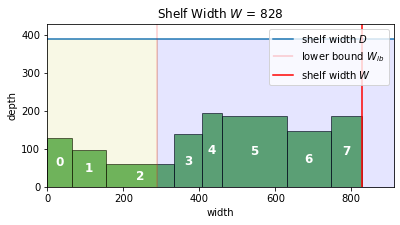

In [2]:
def pack_boxes_V0(boxes):
    soln = boxes.copy()
    soln["x1"] = soln["w"].cumsum() - soln["w"]
    soln["x2"] = soln["w"].cumsum()
    soln["y1"] = 0
    soln["y2"] = soln["d"]
    soln["r"] = 0
    return soln

def show_boxes(boxes, D):
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    for i, x, y, w, h, r in zip(boxes.index, boxes["x1"], boxes["y1"], 
                                boxes["w"], boxes["d"], boxes["r"]):
        c = "g"
        if r == 1:
            h, w = w, h
            c = "r"
        ax.add_patch(Rectangle((x, y), w, h, edgecolor="k", facecolor=c, alpha=0.6))
        ax.annotate(i, (x + w/2, y + h/2), color="w", weight="bold", 
                    fontsize=12, ha="center", va="center")
        
    W_lb = (boxes["w"]*boxes["d"]).sum()/D
    ax.set_xlim(0, 1.1*boxes["w"].sum())
    ax.set_ylim(0, D*1.1)
    ax.axhline(D, label="shelf width $D$")
    ax.axvline(W_lb, label="lower bound $W_{lb}$", color="r", lw=0.3)
    ax.axvline(boxes["x2"].max(), label="shelf width $W$", color="r")
    ax.fill_between([W_lb, ax.get_xlim()[1]], [D, D], color="b", alpha=0.1)
    ax.fill_between([0, W_lb], [D, D], color="y", alpha=0.1)
    ax.set_title(f"Shelf Width $W$ = {boxes['x2'].max():.0f}")
    ax.set_xlabel("width")
    ax.set_ylabel("depth")
    ax.set_aspect('equal')
    ax.legend(loc="upper right")

soln = pack_boxes_V0(boxes)
display(soln)
show_boxes(soln, D)

## Version 1: A Pyomo model to line up the boxes

For this first Pyomo model we look to reproduce a lineup of the boxes on the shelf. In the case the problem is to minimize $W$ where

$$
\begin{align*}
& \min W \\
\text{subject to:}\qquad\qquad \\
x_{i, 2} & = x_{i, 1} + w_i  & \forall i\\
x_{i, 2} & \leq W  & \forall i\\
x_{i, 1}, x_{i, 2} & \geq 0  & \forall i \\
\\
[x_{i, 2} \leq x_{j,1}] & \veebar [ x_{j, 2} \leq x_{i, 1}] & \forall i < j \\
\\
\end{align*}
$$

This first model does not consider rotation or placement of the boxes in the $y$ dimension, so those decisions are not included. 

The disjunctive constraints specify relationships between $x_{i,1}$ and $x_{i,2}$ to prevent overlapping positions of boxes on the shelf. The disjunctions require that either that box $i$ is to the left of box $j$ or that box $j$ is the left of box $i$. This is specified as an exclusive or disjunction because both conditions can be true at the same time. This disjuctive relationship must hold for every pair of boxes that are different from each other, but specifying $i$ doesn't overlap with $j$ assures $j$ doesn't overlap $i$. So it is only necessary to specify disjunctions for all pairs $i, j$ where $i < j$.

The corresponding Pyomo model is a direct implementation of this model. One feature of the implementation is the use of a set `m.PAIRS` to identify the disjunctions. Defining this set simplifies coding for the corresponding disjunction.


,w,d,x1,x2,y1,y2,r
0,65,129,763.0,828.0,0,129,0
1,90,98,673.0,763.0,0,98,0
2,177,59,496.0,673.0,0,59,0
3,76,138,420.0,496.0,0,138,0
4,51,195,369.0,420.0,0,195,0
5,172,187,197.0,369.0,0,187,0
6,114,148,83.0,197.0,0,148,0
7,83,187,0.0,83.0,0,187,0


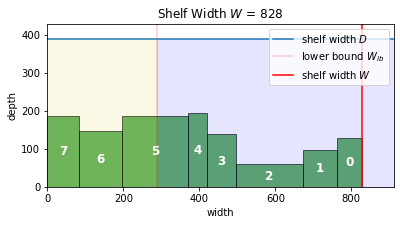

In [3]:
import pyomo.environ as pyo
import pyomo.gdp as gdp

def pack_boxes_V1(boxes):
    
    # a simple upper bound on shelf width
    W_ub = boxes["w"].sum()

    m = pyo.ConcreteModel()

    m.BOXES = pyo.Set(initialize=boxes.index)
    m.PAIRS = pyo.Set(initialize=m.BOXES * m.BOXES, filter=lambda m, i, j: i < j)

    m.W = pyo.Var(domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.x1 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.x2 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))

    @m.Objective()
    def minimize_width(m):
        return m.W
    
    @m.Constraint(m.BOXES)
    def bounding_box(m, i):
        return m.x2[i] == m.x1[i] + boxes.loc[i, "w"]
    
    @m.Constraint(m.BOXES)
    def width(m, i):
        return m.x2[i] <= m.W

    @m.Disjunction(m.PAIRS, xor=True)
    def no_overlap(m, i, j):
        return [m.x2[i] <= m.x1[j],
                m.x2[j] <= m.x1[i]]

    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    solver = pyo.SolverFactory("gurobi_direct")
    solver.solve(m)

    soln = boxes.copy()
    soln["x1"] = [m.x1[i]() for i in boxes.index]
    soln["x2"] = [m.x2[i]() for i in boxes.index]
    soln["y1"] = [0 for i in boxes.index]
    soln["y2"] = soln["y1"] + soln["d"]
    soln["r"] = [0 for i in boxes.index]
    return soln

soln = pack_boxes_V1(boxes)
display(soln)
show_boxes(soln, D)

## Version 2: Rotating boxes

Rotating the boxes is an allowed action in this shelf packing application. This introduces an additional disjunction to determine the orientation of the bounding box. We include a binary indicator variable $r_i$ that will be used to track which boxes were rotated.

$$
\begin{align*}
& \min W \\
\text{subject to:}\qquad\qquad \\
x_{i, 2} & \leq W  & \forall i\\
x_{i, 1}, x_{i, 2} & \geq 0  & \forall i \\
y_{i, 1} & = 0 & \forall i \\
\\
[x_{i, 2} \leq x_{j,1}] & \veebar [ x_{j, 2} \leq x_{i, 1}] & \forall i < j \\
\\
\begin{bmatrix}
r_i = 0 \\
x_{i,2} = x_{i,1} + w_i\\
y_{i,2} = y_{i,1} + d_i\\
\end{bmatrix} & \veebar 
\begin{bmatrix}
r_i = 1 \\
x_{i,2} = x_{i,1} + d_i\\
y_{i,2} = y_{i,1} + w_i\\
\end{bmatrix} & \forall i < j
\end{align*}
$$

The Pyomo model implementation now adds the decision variables for rotation and $y$ position.

,w,d,x1,x2,y1,y2,r
0,65,129,480.0,545.0,0.0,129.0,0.0
1,90,98,390.0,480.0,0.0,98.0,0.0
2,177,59,0.0,59.0,0.0,177.0,1.0
3,76,138,314.0,390.0,0.0,138.0,0.0
4,51,195,545.0,596.0,0.0,195.0,0.0
5,172,187,59.0,231.0,0.0,187.0,0.0
6,114,148,596.0,710.0,0.0,148.0,0.0
7,83,187,231.0,314.0,0.0,187.0,0.0


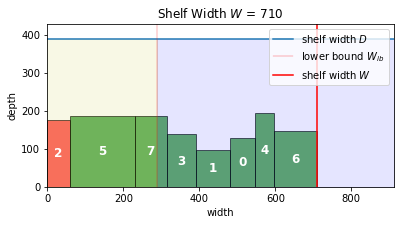

In [4]:
import pyomo.environ as pyo
import pyomo.gdp as gdp

def pack_boxes_V2(boxes):
    
    W_ub = boxes["w"].sum()

    m = pyo.ConcreteModel()

    m.BOXES = pyo.Set(initialize=boxes.index)
    m.PAIRS = pyo.Set(initialize=m.BOXES * m.BOXES, filter=lambda m, i, j: i < j)

    m.W = pyo.Var(domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.x1 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.x2 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.y1 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.y2 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.r = pyo.Var(m.BOXES, domain=pyo.Binary)

    @m.Objective()
    def minimize_width(m):
        return m.W
    
    @m.Constraint(m.BOXES)
    def width(m, i):
        return m.x2[i] <= m.W
    
    @m.Constraint(m.BOXES)
    def yloc(m, i):
        return m.y1[i] == 0
    
    @m.Disjunction(m.BOXES)
    def rotate(m, i):
        return [[m.r[i] == 0, 
                 m.x2[i] == m.x1[i] + boxes.loc[i, "w"],
                 m.y2[i] == m.y1[i] + boxes.loc[i, "d"]],
                
                [m.r[i] == 1, 
                 m.x2[i] == m.x1[i] + boxes.loc[i, "d"],
                 m.y2[i] == m.y1[i] + boxes.loc[i, "w"]]
               ]

    @m.Disjunction(m.PAIRS)
    def no_overlap(m, i, j):
        return [m.x2[i] <= m.x1[j],
                m.x2[j] <= m.x1[i]]

    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    solver = pyo.SolverFactory("gurobi_direct")
    solver.solve(m)

    soln = boxes.copy()
    soln["x1"] = [m.x1[i]() for i in boxes.index]
    soln["x2"] = [m.x2[i]() for i in boxes.index]
    soln["y1"] = [m.y1[i]() for i in boxes.index]
    soln["y2"] = [m.y2[i]() for i in boxes.index]
    soln["r"] = [m.r[i]() for i in boxes.index]
    
    return soln

soln = pack_boxes_V2(boxes)
display(soln)
show_boxes(soln, D)

## Version 3: Placing and Rotating boxes in two dimensions

Obiously the packages can be packed closer together by allowing boxes to be stacked deeper into the shelf. New constraints are needed to maintain the bounding boxes within the shelf depth, and to avoid overlaps in the $y$ dimension.

$$
\begin{align*}
& \min W \\
\text{subject to:}\qquad\qquad \\
x_{i, 2} & \leq W & \forall i\\
y_{i, 2} & \leq D & \forall i\\
x_{i, 1}, x_{i, 2} & \geq 0  & \forall i \\
y_{i, 1}, y_{i, 2} & \geq 0 & \forall i \\
\\
\begin{bmatrix}
x_{i, 2} \leq x_{j,1} \\
\end{bmatrix}
\veebar
\begin{bmatrix}
x_{j, 2} \leq x_{i, 1} \\
\end{bmatrix}
& \veebar 
\begin{bmatrix}
y_{i, 2} \leq y_{j, 1} \\
\end{bmatrix}
\veebar
\begin{bmatrix}
y_{j, 2} \leq y_{i, 1} \\
\end{bmatrix}
& \forall i < j \\
\\
\begin{bmatrix}
r_i = 0 \\
x_{i,2} = x_{i,1} + w_i\\
y_{i,2} = y_{i,1} + d_i\\
\end{bmatrix} & \veebar 
\begin{bmatrix}
r_i = 1 \\
x_{i,2} = x_{i,1} + d_i\\
y_{i,2} = y_{i,1} + w_i\\
\end{bmatrix} & \forall i < j
\end{align*}
$$


,w,d,x1,x2,y1,y2,r
0,65,129,238.0,303.0,0.0,129.0,0.0
1,90,98,189.0,279.0,144.0,242.0,0.0
2,177,59,51.0,228.0,83.0,142.0,0.0
3,76,138,51.0,189.0,142.0,218.0,1.0
4,51,195,0.0,51.0,0.0,195.0,0.0
5,172,187,0.0,187.0,218.0,390.0,1.0
6,114,148,187.0,301.0,242.0,390.0,0.0
7,83,187,51.0,238.0,0.0,83.0,1.0


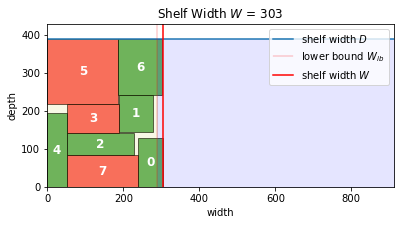

In [5]:
import pyomo.environ as pyo
import pyomo.gdp as gdp

def pack_boxes_V3(boxes, D):
    
    W_ub = boxes["w"].sum()

    m = pyo.ConcreteModel()
    
    m.D = pyo.Param(mutable=True, initialize=D)

    m.BOXES = pyo.Set(initialize=boxes.index)
    m.PAIRS = pyo.Set(initialize=m.BOXES * m.BOXES, filter=lambda m, i, j: i < j)

    m.W = pyo.Var(domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.x1 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.x2 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.y1 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.y2 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.r = pyo.Var(m.BOXES, domain=pyo.Binary)

    @m.Objective()
    def minimize_width(m):
        return m.W
    
    @m.Constraint(m.BOXES)
    def width(m, i):
        return m.x2[i] <= m.W
    
    @m.Constraint(m.BOXES)
    def height(m, i):
        return m.y2[i] <= m.D
    
    @m.Disjunction(m.BOXES)
    def rotate(m, i):
        return [[m.r[i] == 0, 
                 m.x2[i] == m.x1[i] + boxes.loc[i, "w"],
                 m.y2[i] == m.y1[i] + boxes.loc[i, "d"]],
                
                [m.r[i] == 1, 
                 m.x2[i] == m.x1[i] + boxes.loc[i, "d"],
                 m.y2[i] == m.y1[i] + boxes.loc[i, "w"]]
               ]

    @m.Disjunction(m.PAIRS)
    def no_overlap(m, i, j):
        return [m.x2[i] <= m.x1[j],
                m.x2[j] <= m.x1[i],
                m.y2[i] <= m.y1[j],
                m.y2[j] <= m.y1[i]]

    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    solver = pyo.SolverFactory("gurobi_direct")
    solver.solve(m)

    soln = boxes.copy()
    soln["x1"] = [m.x1[i]() for i in boxes.index]
    soln["x2"] = [m.x2[i]() for i in boxes.index]
    soln["y1"] = [m.y1[i]() for i in boxes.index]
    soln["y2"] = [m.y2[i]() for i in boxes.index]
    soln["r"] = [m.r[i]() for i in boxes.index]
    return soln

soln = pack_boxes_V3(boxes, D)
display(soln)
show_boxes(soln, D)

## Advanced Topic: Symmetry Breaking

One of the issues in combinatorial problem is the challenge of symmetries. A symmetry is a sitatuion where a change in solution configuration leaves the objective unchanged. Strip packing problems are especially susceptable to symmetries.

Symmetries can significantly increase the effort needed to find and and verify an optimal solution. Trespalacios and Grossmann recently presented modification to the strip packing problem to reduce the number of symmetries. This is described in the following paper and implemented in the accompanying Pyomo model.

While symmetry breaking does speed up solutioin of sample problems, the netw

Trespalacios, F., & Grossmann, I. E. (2017). Symmetry breaking for generalized disjunctive programming formulation of the strip packing problem. Annals of Operations Research, 258(2), 747-759.


,w,d,x1,x2,y1,y2,r
0,65,129,238.0,303.0,0.0,129.0,0.0
1,90,98,205.0,303.0,290.0,380.0,1.0
2,177,59,61.0,238.0,0.0,59.0,0.0
3,76,138,51.0,189.0,142.0,218.0,1.0
4,51,195,0.0,51.0,0.0,195.0,0.0
5,172,187,0.0,187.0,218.0,390.0,1.0
6,114,148,189.0,303.0,142.0,290.0,0.0
7,83,187,51.0,238.0,59.0,142.0,1.0


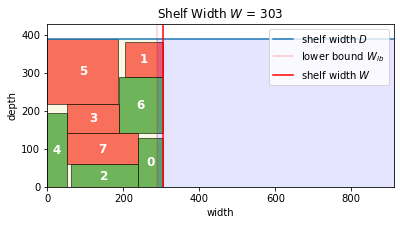

In [6]:
import pyomo.environ as pyo
import pyomo.gdp as gdp

def pack_boxes_V4(boxes, D):
    
    W_ub = boxes["w"].sum()

    m = pyo.ConcreteModel()
    
    m.D = pyo.Param(mutable=True, initialize=D)

    m.BOXES = pyo.Set(initialize=boxes.index)
    m.PAIRS = pyo.Set(initialize=m.BOXES * m.BOXES, filter=lambda m, i, j: i < j)

    m.W = pyo.Var(domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.x1 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.x2 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.y1 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.y2 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.r = pyo.Var(m.BOXES, domain=pyo.Binary)

    @m.Objective()
    def minimize_width(m):
        return m.W
    
    @m.Constraint(m.BOXES)
    def width(m, i):
        return m.x2[i] <= m.W
    
    @m.Constraint(m.BOXES)
    def height(m, i):
        return m.y2[i] <= m.D
    
    @m.Disjunction(m.BOXES)
    def rotate(m, i):
        return [[m.r[i] == 0, 
                 m.x2[i] == m.x1[i] + boxes.loc[i, "w"],
                 m.y2[i] == m.y1[i] + boxes.loc[i, "d"]],
                
                [m.r[i] == 1, 
                 m.x2[i] == m.x1[i] + boxes.loc[i, "d"],
                 m.y2[i] == m.y1[i] + boxes.loc[i, "w"]]
               ]

    @m.Disjunction(m.PAIRS)
    def no_overlap(m, i, j):
        return [[m.x2[i] <= m.x1[j]],
                
                [m.x2[j] <= m.x1[i]],
                
                [m.y2[i] <= m.y1[j],
                 m.x2[i] >= m.x1[j] + 1,
                 m.x2[j] >= m.x1[i] + 1],
                
                [m.y2[j] <= m.y1[i],
                 m.x2[i] >= m.x1[j] + 1,
                 m.x2[j] >= m.x1[i] + 1]
               ]

    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    solver = pyo.SolverFactory("gurobi_direct")
    solver.solve(m)

    soln = boxes.copy()
    soln["x1"] = [m.x1[i]() for i in boxes.index]
    soln["x2"] = [m.x2[i]() for i in boxes.index]
    soln["y1"] = [m.y1[i]() for i in boxes.index]
    soln["y2"] = [m.y2[i]() for i in boxes.index]
    soln["r"] = [m.r[i]() for i in boxes.index]
    return soln

soln = pack_boxes_V4(boxes, D)
display(soln)
show_boxes(soln, D)